# Notebook for Setting Up, Training, and Visualization of MultiVI‑Splice (MuData Version)
 
This notebook:
1. Imports required libraries.
2. Loads GE and ATSE AnnData objects.
3. Processes and cleans splicing data (e.g. fixes NaNs).
4. Creates modality‑specific AnnData objects and stacks them into a single MuData object.
5. Sets up MultiVI‑Splice using the MuData.
6. Trains the model (with W&B logging), saves it, and retrieves imputed estimates.
7. Visualizes the latent representation via UMAP.
8. Optionally writes out the updated MuData object.
  

## 0. Configure Paths

In [28]:
# Change these as needed:
COMBINED_ANNDATA_PATH = "/gpfs/commons/groups/knowles_lab/Karin/TMS_MODELING/DATA_FILES/BRAIN_ONLY/02112025/TMS_BRAINONLY_Combined_GE_ATSE.h5ad"
MODEL_SAVE_DIR = "/gpfs/commons/home/svaidyanathan/repos/multivi_tools_splicing/models/multivi_brain_only.pth"
IMPUTED_DFS_PATH = "/gpfs/commons/home/svaidyanathan/repos/multivi_tools_splicing/dfs/imputed_dfs.h5"
OPTIONAL_ANNDATA_MULTIVI_LATENT_SPACE_PATH = "/gpfs/commons/groups/knowles_lab/Karin/TMS_MODELING/DATA_FILES/BRAIN_ONLY/02112025/MULTIVI_TMS_BRAINONLY_Combined_GE_ATSE.h5ad"

print("Using combined AnnData from:", COMBINED_ANNDATA_PATH)
print("Model save directory:", MODEL_SAVE_DIR)
print("Imputed DataFrame file:", IMPUTED_DFS_PATH)
print("AnnData with Latent Space path:", OPTIONAL_ANNDATA_MULTIVI_LATENT_SPACE_PATH)

Using combined AnnData from: /gpfs/commons/groups/knowles_lab/Karin/TMS_MODELING/DATA_FILES/BRAIN_ONLY/02112025/TMS_BRAINONLY_Combined_GE_ATSE.h5ad
Model save directory: /gpfs/commons/home/svaidyanathan/repos/multivi_tools_splicing/models/multivi_brain_only.pth
Imputed DataFrame file: /gpfs/commons/home/svaidyanathan/repos/multivi_tools_splicing/dfs/imputed_dfs.h5
AnnData with Latent Space path: /gpfs/commons/groups/knowles_lab/Karin/TMS_MODELING/DATA_FILES/BRAIN_ONLY/02112025/MULTIVI_TMS_BRAINONLY_Combined_GE_ATSE.h5ad


## 1. Imports

In [29]:
import jax
import jaxlib
print("jax version:", jax.__version__)
print("jaxlib version:", jaxlib.__version__)

import scvi  # local copy of scvi-tools
print(scvi.__version__)
import h5py
import scanpy as sc
import anndata as ad
import pandas as pd
import scipy.sparse as sp
import numpy as np
import wandb
from pytorch_lightning.loggers import WandbLogger
import matplotlib.pyplot as plt

jax version: 0.5.0
jaxlib version: 0.5.0
1.2.0


## 2. Initialize W&B Logger (Optional)Loading in our stacked annData (created using the ann_data_maker notebook).

In [25]:
wandb_logger = WandbLogger(project="multivi-splice")  

## 3. Load Combined AnnData

We assume this AnnData has all necessary fields (e.g. `mouse.id`, `.layers["cell_by_junction_matrix"]`, etc.)

In [26]:
combined_adata = ad.read_h5ad(COMBINED_ANNDATA_PATH)
print("Combined AnnData shape:", combined_adata.shape)
print("Observations (obs) columns:", combined_adata.obs.columns)
print("Variables (var) columns:", combined_adata.var.columns)

Combined AnnData shape: (19942, 83961)
Observations (obs) columns: Index(['batch_id', 'age', 'cell_ontology_class', 'cell_type_grouped',
       'mouse.id', 'sex', 'modality'],
      dtype='object')
Variables (var) columns: Index(['ID', 'modality'], dtype='object')


## 4. Setup MultiVI-Splice Model

- We specify the `batch_key`, `atse_counts`, and `junc_counts` keys to match the combined AnnData.
- Then create a `MULTIVISPLICE` model counting how many genes vs. splicing variables.

In [27]:
scvi.model.MULTIVISPLICE.setup_anndata(
    combined_adata,
    batch_key="mouse.id",
    atse_counts="cell_by_cluster_matrix",  # adjust if needed
    junc_counts="cell_by_junction_matrix",  # adjust if needed
)

model = scvi.model.MULTIVISPLICE(
    combined_adata,
    n_genes=(combined_adata.var["modality"] == "Gene_Expression").sum(),
    n_junctions=(combined_adata.var["modality"] == "Splicing").sum(),
)
model.view_anndata_setup()

AttributeError: module 'scvi' has no attribute '__version__'

## 5. Train Model (with W&B Logging) and Save

If you don't want to log to W&B, remove `logger=wandb_logger`.

In [ ]:
model.train(logger=wandb_logger)

model.save(MODEL_SAVE_DIR, overwrite=True)
print(f"Model saved to: {MODEL_SAVE_DIR}")

## 6. (Optional) Reload Model

Reload the trained model from disk if you want to use it in a new session.

In [14]:
model = scvi.model.MULTIVISPLICE.load(MODEL_SAVE_DIR, adata=combined_adata)
print("Model reloaded. Current AnnData shape:", combined_adata.shape)

AnnData object with n_obs × n_vars = 19942 × 77042
    obs: 'batch_id', 'modality', 'mouse.id', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'ID', 'modality', 'n_cells'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    layers: 'cell_by_cluster_matrix', 'cell_by_junction_matrix'

## 7. Retrieve Imputed Splicing/Expression

- `get_splicing_estimates()` returns imputed splicing usage ratios.
- `get_normalized_expression()` returns normalized gene expression.
- We store them in an HDF5 file for further analysis.

In [8]:

imputed_splicing_estimates = model.get_splicing_estimates()
imputed_splicing_estimates.to_hdf(IMPUTED_DFS_PATH, key="imputed_splicing_estimates", mode="w")
imputed_splicing_estimates = None

imputed_expression_estimates = model.get_normalized_expression()
imputed_expression_estimates.to_hdf(IMPUTED_DFS_PATH, key="imputed_expression_estimates", mode="a")
imputed_expression_estimates = None

print(f"Imputed splicing and expression DataFrames stored in {IMPUTED_DFS_PATH}")

## 8. Visualize Latent Representation (UMAP)

1. Add the model's latent representation to `.obsm`.
2. Calculate neighbors/UMAP.
3. Plot with different color labels.

Getting the latent representation and adding it as an obsm field called "X_multivi"

AnnData object with n_obs × n_vars = 19942 × 22966
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'cell_clean', 'cell_id', 'batch', 'old_cell_id_index', 'cell_id_index', 'subtissue_clean', 'cell_type_grouped', 'leiden'
    var: 'n_cells', 'mouse_gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts'
    obsp: 'connectivities', 'distances'


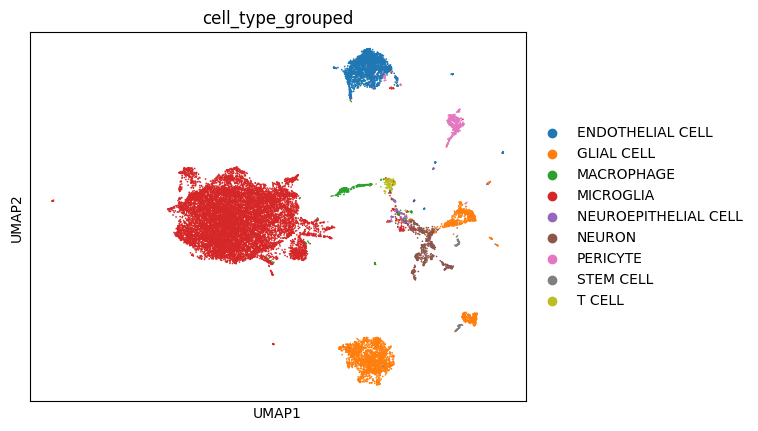

In [10]:
MULTIVI_LATENT_KEY = "X_multivi"
combined_adata.obsm[MULTIVI_LATENT_KEY] = model.get_latent_representation()

sc.pp.neighbors(combined_adata, use_rep=MULTIVI_LATENT_KEY)
sc.tl.umap(combined_adata, min_dist=0.2)

# Plot by different obs fields
fields_to_plot = ["modality", "cell_type_grouped", "age", "sex"]
for field in fields_to_plot:
    if field in combined_adata.obs.columns:
        sc.pl.umap(combined_adata, color=field)

## 9. (Optional) Write Updated AnnData

Includes the new `.obsm["X_multivi"]` for further usage.

In [17]:
combined_adata.write(OPTIONAL_ANNDATA_MULTIVI_LATENT_SPACE_PATH)
print(f"Updated AnnData with latent space written to: {OPTIONAL_ANNDATA_MULTIVI_LATENT_SPACE_PATH}")

AnnData object with n_obs × n_vars = 19942 × 77042
    obs: 'batch_id', 'modality', 'mouse.id', '_indices', '_scvi_batch', '_scvi_labels', 'age', 'sex', 'cell_type_grouped', 'cell_ontology_class'
    var: 'ID', 'modality', 'n_cells'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'GE_X_umap'
    layers: 'cell_by_cluster_matrix', 'cell_by_junction_matrix'


## 10. Custom Plot Example

Manual plotting with matplotlib if you want custom styling or a side-by-side figure.

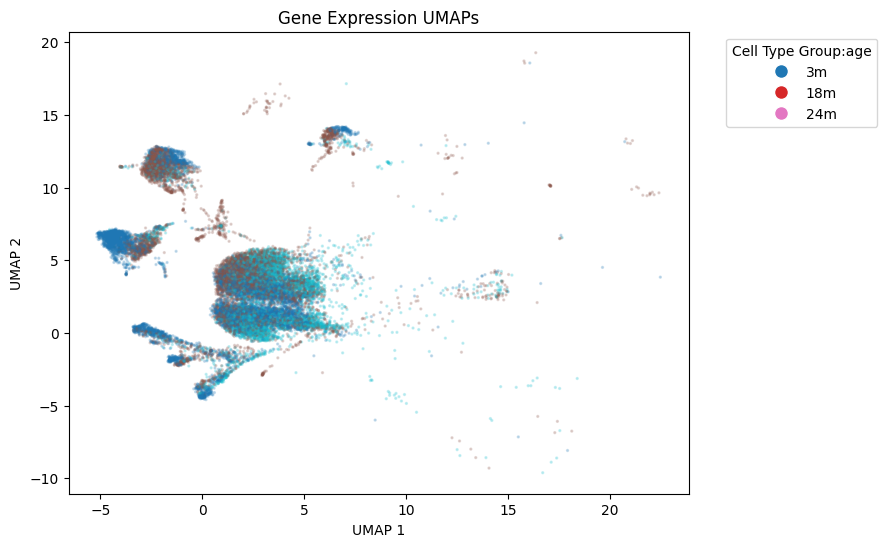

In [19]:
plt.figure(figsize=(8, 6))
group = "age"  # or any column in combined_adata.obs
if group in combined_adata.obs.columns:
    cell_types = combined_adata.obs[group].astype("category")
    umap_coords = combined_adata.obsm["X_umap"]

    scatter = plt.scatter(
        umap_coords[:, 0],
        umap_coords[:, 1],
        c=cell_types.cat.codes,
        cmap="tab10",
        alpha=0.2,
        s=2
    )
    legend_labels = cell_types.cat.categories
    legend_handles = [
        plt.Line2D(
            [0], [0],
            marker="o",
            color="w",
            markerfacecolor=plt.cm.tab10(i / len(legend_labels)),
            markersize=10
        )
        for i in range(len(legend_labels))
    ]
    plt.legend(
        legend_handles, legend_labels,
        title=f"UMAP colored by: {group}",
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )

    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.title(f"UMAP (field: {group})")
    plt.show()
else:
    print(f"Column '{group}' not found in .obs.")